In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from matplotlib.colors import LinearSegmentedColormap

import plotly.express as px

from sqlalchemy import create_engine
import pymysql
from pymysql.cursors import DictCursor
import pymysql.cursors

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, precision_recall_curve

import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

# DATA QUERY

In [3]:
username = 'root'          
password = ''               
host = 'localhost'         
port = '3306'              
database = 'top7_leagues' 

# Create the SQLAlchemy engine
engine = create_engine(f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}')

In [4]:
query = "SELECT * FROM match_events_2023_24"
df_events = pd.read_sql(query, engine)

In [5]:
df_events.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,blocked_x,blocked_y,goal_mouth_z,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name
0,2602361573,1734766,3,0,0.0,54,135366,50.1,50.0,46.4,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
1,2602361601,1734766,4,0,1.0,54,82989,46.1,49.7,31.9,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
2,2602361647,1734766,5,0,4.0,54,125211,31.8,13.1,20.8,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
3,2602361695,1734766,6,0,6.0,54,121456,20.8,30.8,20.1,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf
4,2602361767,1734766,7,0,9.0,54,454342,19.4,64.2,18.1,...,NaN,NaN,NaN,NaN,0,0,0,Pass,Successful,FirstHalf


In [21]:
query2 = "SELECT * FROM players_info_2023_24"
df_players = pd.read_sql(query2, engine)

In [22]:
df_teams = df_players[['team_id', 'team_name']].drop_duplicates()

# DATA PROCESSING

## Data Standardization and Cleanup

In [6]:
def transform_data(df_events):
    
    # Apply transformations to x and y coordinates (intially 100 x 100)
    for col in ['x', 'end_x','blocked_x']:
        df_events.loc[:, col] *= 1.2
    for col in ['y', 'end_y', 'blocked_y', 'goal_mouth_y']:
        df_events.loc[:, col] = 80 - (df_events[col] * 0.8)    

    df_shots = df_events[(df_events['is_shot']==1) & (df_events['x']>40)]

    df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)
        
    # Goal center coordinates
    goal_x = 120
    goal_y = 40

    # Calculate shot distance & angle

    df_shots['shot_distance'] = np.sqrt((df_shots['x'] - goal_x)**2 + (df_shots['y'] - goal_y)**2)
    
    df_shots['shot_angle'] = np.arctan2(np.abs(df_shots['y'] - goal_y), np.abs(goal_x - df_shots['x']))
    df_shots['shot_angle_deg'] = np.degrees(df_shots['shot_angle'])
    df_shots = df_shots.drop(columns=['shot_angle'])

    return df_shots

In [7]:
df_shots = transform_data(df_events)

In [8]:
df_shots.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,goal_mouth_y,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,is_penalty,shot_distance,shot_angle_deg
75,2602367713,1734766,41,4,13.0,60,370000,117.48,47.68,NaN,...,46.64,1,0,0,MissedShots,Successful,FirstHalf,0,8.082871,71.834043
217,2602380121,1734766,99,12,40.0,60,345908,97.32,41.92,NaN,...,41.84,1,0,0,SavedShot,Successful,FirstHalf,0,22.761125,4.838899
296,2602385821,1734766,151,17,2.0,60,79840,110.04,35.60,NaN,...,33.60,1,0,0,MissedShots,Successful,FirstHalf,0,10.888600,23.834263
305,2602386809,1734766,158,17,56.0,60,79840,107.40,35.60,NaN,...,37.12,1,0,0,MissedShots,Successful,FirstHalf,0,13.346160,19.249526
395,2602392055,1734766,253,23,46.0,54,395188,108.12,22.88,NaN,...,44.48,1,0,0,ShotOnPost,Successful,FirstHalf,0,20.838157,55.242243


## % of scoring based on Distance, Angle & Minute

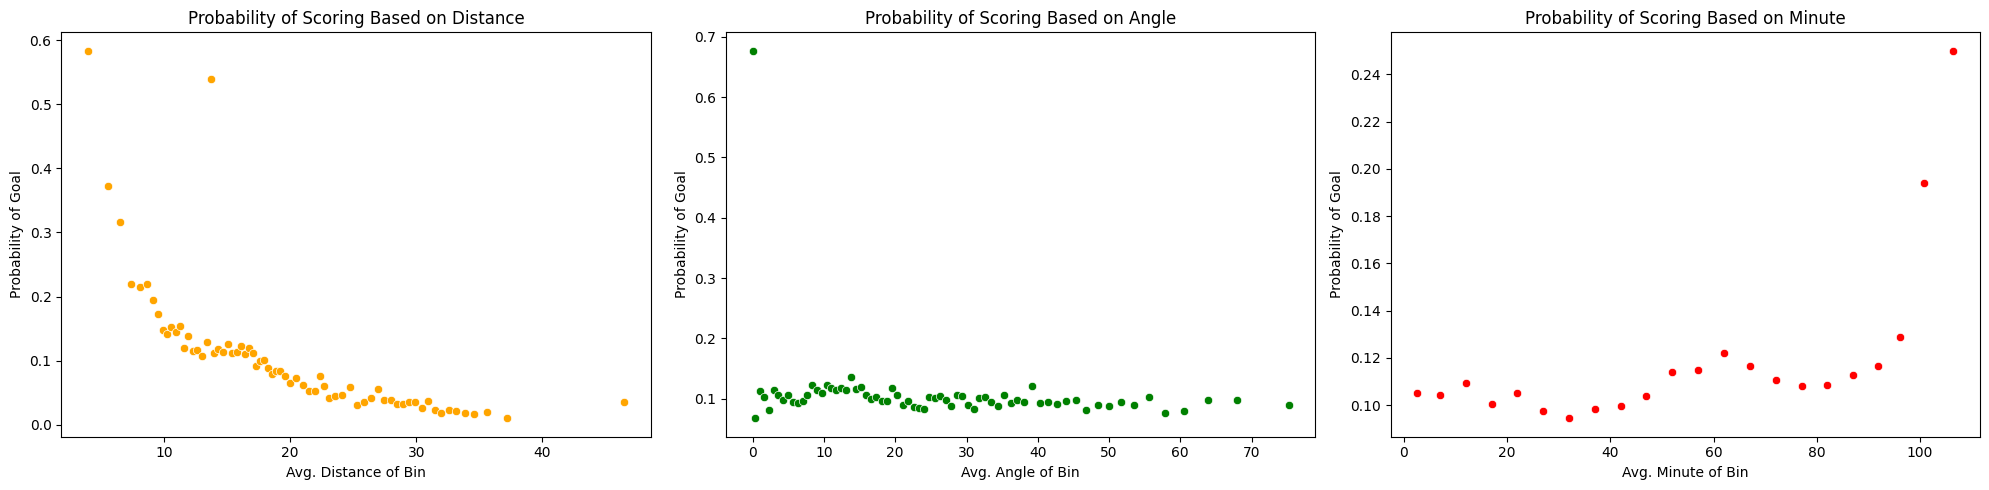

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. Probability of Scoring Based on Distance
df_shots['Distance_Bins'] = pd.qcut(df_shots['shot_distance'], q=70)
dist_prob = df_shots.groupby('Distance_Bins', as_index=False)['is_goal'].mean()
dist_mean = df_shots.groupby('Distance_Bins', as_index=False)['shot_distance'].mean()
sns.scatterplot(x=dist_mean['shot_distance'], y=dist_prob['is_goal'], ax=axes[0], color="orange")
axes[0].set_xlabel("Avg. Distance of Bin")
axes[0].set_ylabel("Probability of Goal")
axes[0].set_title("Probability of Scoring Based on Distance")

# 2. Probability of Scoring Based on Angle
df_shots['Angle_Bins'] = pd.qcut(df_shots['shot_angle_deg'], q=70)
angle_prob = df_shots.groupby('Angle_Bins', as_index=False)['is_goal'].mean()
angle_mean = df_shots.groupby('Angle_Bins', as_index=False)['shot_angle_deg'].mean()
sns.scatterplot(x=angle_mean['shot_angle_deg'], y=angle_prob['is_goal'], ax=axes[1], color="green")
axes[1].set_xlabel("Avg. Angle of Bin")
axes[1].set_ylabel("Probability of Goal")
axes[1].set_title("Probability of Scoring Based on Angle")

# 3. Probability of Scoring Based on Minute
minute_bins = np.linspace(df_shots['minute'].min(), df_shots['minute'].max(), 23)
df_shots['Minute_Bins'] = pd.cut(df_shots['minute'], bins=minute_bins)
minute_prob = df_shots.groupby('Minute_Bins', as_index=False)['is_goal'].mean()
minute_mean = df_shots.groupby('Minute_Bins', as_index=False)['minute'].mean()
sns.scatterplot(x=minute_mean['minute'], y=minute_prob['is_goal'], ax=axes[2], color="red")
axes[2].set_xlabel("Avg. Minute of Bin")
axes[2].set_ylabel("Probability of Goal")
axes[2].set_title("Probability of Scoring Based on Minute")

df_shots.drop(columns=['Distance_Bins', 'Angle_Bins', 'Minute_Bins'], inplace=True)

plt.tight_layout()
plt.show()

The distance feature shows a clearer pattern in the probability of scoring compared to the angle and minute features.

# MACHINE LEARNING

## Data split

In [10]:
# Define features and target
features = ['shot_distance', 'shot_angle_deg','is_penalty','x','y']
target = 'is_goal'

# Define feature matrix and target vector
X = df_shots[features]
y = df_shots[target]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = X_train  # Use raw data without scaling
X_test_scaled = X_test

## Model Training

3 different ML models are being used to predict wether a shot is a goal or not : 

Model 1 = Logistic Regression /
Model 2 = Random Forest /
Model 3 = xGBoost

In [11]:
# Initialize models
lr_model = LogisticRegression(max_iter=100)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)

# Train Logistic Regression
lr_model.fit(X_train_scaled, y_train)

# Train Random Forest
rf_model.fit(X_train_scaled, y_train)

# Train XGBoost
xgb_model.fit(X_train_scaled, y_train)

# Make predictions for each model
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1]

y_pred_rf = rf_model.predict(X_test_scaled)
y_prob_rf = rf_model.predict_proba(X_test_scaled)[:, 1]

y_pred_xgb = xgb_model.predict(X_test_scaled)
y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]

## Results

In [12]:
# Generate classification reports and ROC AUC scores for each model
results = {
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "Accuracy": [
        roc_auc_score(y_test, y_prob_lr),
        roc_auc_score(y_test, y_prob_rf),
        roc_auc_score(y_test, y_prob_xgb)
    ],
    "Precision Non-Goal": [
        classification_report(y_test, y_pred_lr, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_rf, output_dict=True)['0']['precision'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['0']['precision']
    ],
    "Precision Goal": [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['precision']
    ],
    "Recall Non-Goal": [
        classification_report(y_test, y_pred_lr, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_rf, output_dict=True)['0']['recall'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['0']['recall']
    ],
    "Recall Goal": [
        classification_report(y_test, y_pred_lr, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_xgb, output_dict=True)['1']['recall']
    ]
}

models_results = pd.DataFrame(results)
models_results

,Model,Accuracy,Precision Non-Goal,Precision Goal,Recall Non-Goal,Recall Goal
0,Logistic Regression,0.749995,0.897632,0.807860,0.997345,0.089372
1,Random Forest,0.680713,0.906937,0.369028,0.953780,0.216425
2,XGBoost,0.735937,0.903805,0.670124,0.990406,0.156039


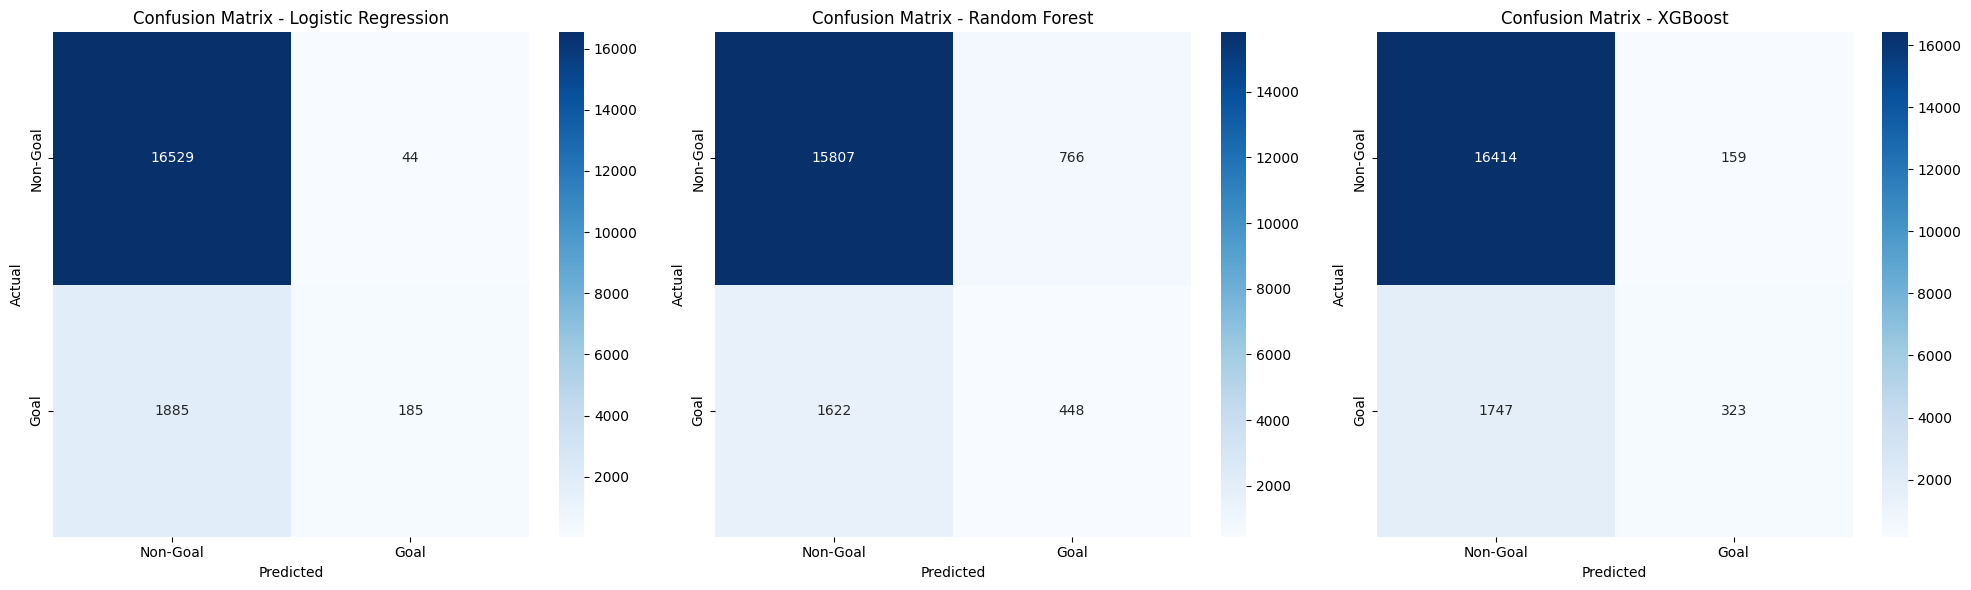

In [13]:
# Confusion Matrices
conf_matrix_lr = confusion_matrix(y_test, y_pred_lr)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Plotting confusion matrices in subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Logistic Regression Confusion Matrix
sns.heatmap(conf_matrix_lr, annot=True, fmt='d', cmap='Blues', ax=ax[0],
            xticklabels=['Non-Goal', 'Goal'], yticklabels=['Non-Goal', 'Goal'])
ax[0].set_title('Confusion Matrix - Logistic Regression')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

# Random Forest Confusion Matrix
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', ax=ax[1],
            xticklabels=['Non-Goal', 'Goal'], yticklabels=['Non-Goal', 'Goal'])
ax[1].set_title('Confusion Matrix - Random Forest')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

# XGBoost Confusion Matrix
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues', ax=ax[2],
            xticklabels=['Non-Goal', 'Goal'], yticklabels=['Non-Goal', 'Goal'])
ax[2].set_title('Confusion Matrix - XGBoost')
ax[2].set_xlabel('Predicted')
ax[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

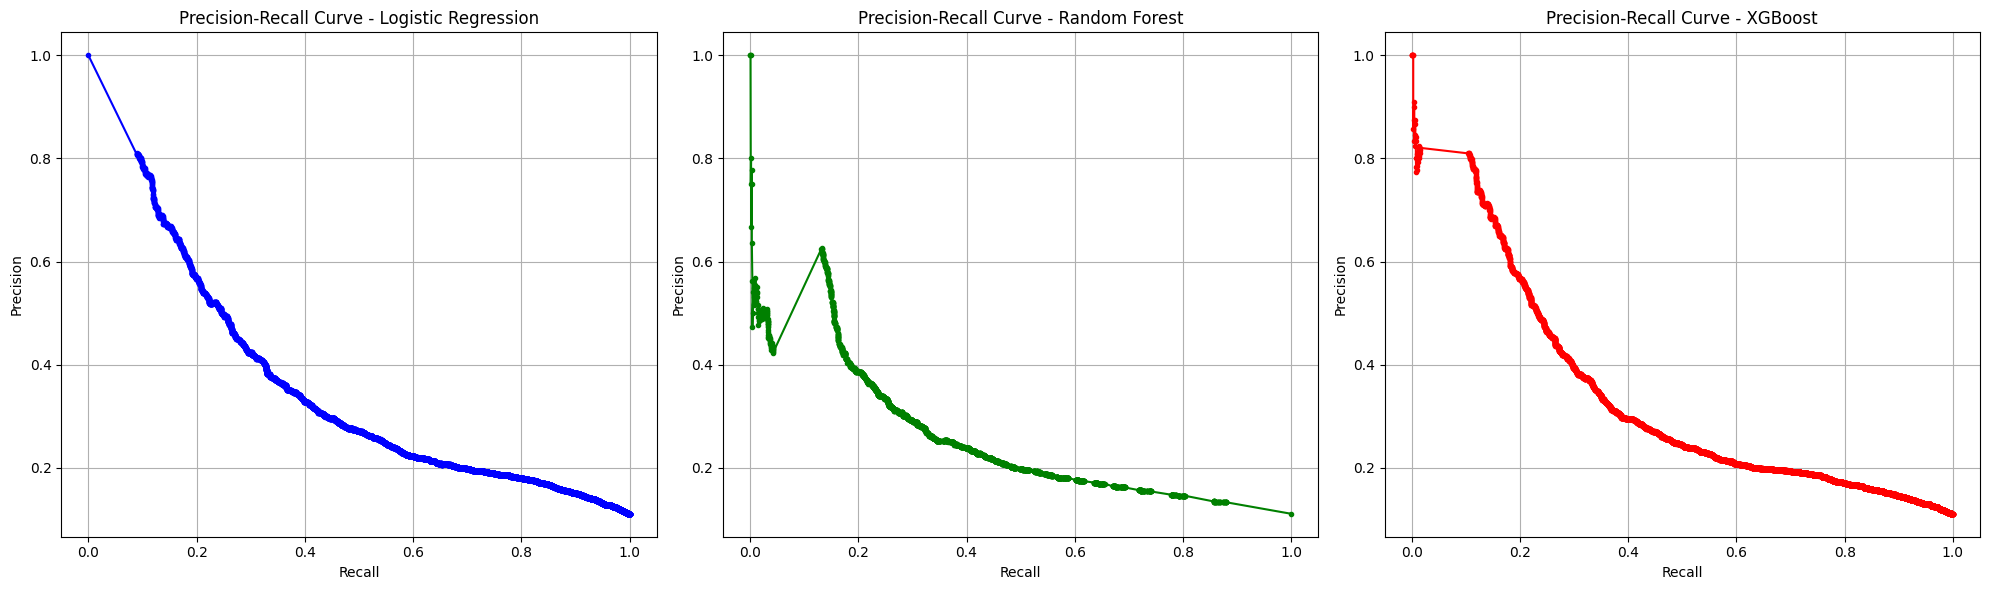

In [14]:
# Compute Precision-Recall curve for each model
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_prob_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_prob_rf)
precision_xgb, recall_xgb, _ = precision_recall_curve(y_test, y_prob_xgb)

# Plotting Precision-Recall curves in subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Logistic Regression Precision-Recall Curve
ax[0].plot(recall_lr, precision_lr, marker='.', color='b')
ax[0].set_xlabel('Recall')
ax[0].set_ylabel('Precision')
ax[0].set_title('Precision-Recall Curve - Logistic Regression')
ax[0].grid(True)

# Random Forest Precision-Recall Curve
ax[1].plot(recall_rf, precision_rf, marker='.', color='g')
ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_title('Precision-Recall Curve - Random Forest')
ax[1].grid(True)

# XGBoost Precision-Recall Curve
ax[2].plot(recall_xgb, precision_xgb, marker='.', color='r')
ax[2].set_xlabel('Recall')
ax[2].set_ylabel('Precision')
ax[2].set_title('Precision-Recall Curve - XGBoost')
ax[2].grid(True)

plt.tight_layout()
plt.show()

These results (Accuracy, Confusion Matrix & Precision-Recall Curves) suggests that the XGBoost model is more suitable to our analysis, and actually performs well (0.73 Accuracy) in identifying wether a shot is a goal or not. 

## Feature importance

<Figure size 1000x800 with 0 Axes>

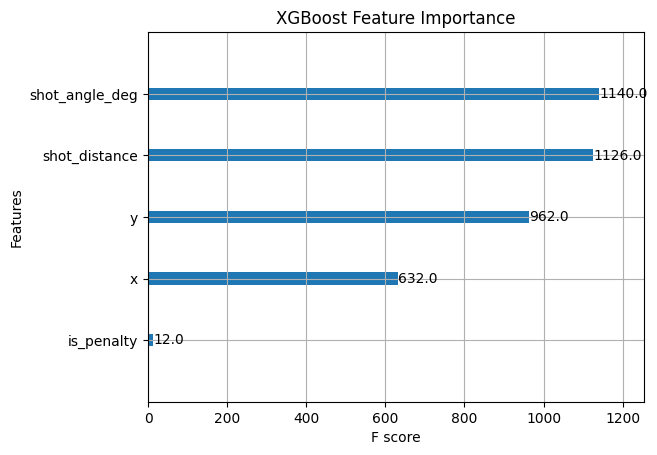

In [17]:
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
xgb.plot_importance(xgb_model, importance_type='weight')  # You can also try 'gain' or 'cover' types
plt.title('XGBoost Feature Importance')
plt.ylabel('Features')
plt.show()

## xG calculation

In [23]:
# Create a subset DataFrame with only the features required for prediction
df_shots_numeric = df_shots[features]

# Generate xG predictions based on the selected numeric columns
xg_predictions = xgb_model.predict_proba(df_shots_numeric)[:, 1]  # Get probability for 'goal' (class 1)

#Add the xG predictions back to the original DataFrame
df_shots['xG'] = xg_predictions

In [24]:
df_shots.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,is_penalty,shot_distance,shot_angle_deg,xG
75,2602367713,1734766,41,4,13.0,60,370000,117.48,47.68,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,8.082871,71.834043,0.102411
217,2602380121,1734766,99,12,40.0,60,345908,97.32,41.92,NaN,...,1,0,0,SavedShot,Successful,FirstHalf,0,22.761125,4.838899,0.032292
296,2602385821,1734766,151,17,2.0,60,79840,110.04,35.60,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,10.888600,23.834263,0.171072
305,2602386809,1734766,158,17,56.0,60,79840,107.40,35.60,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,13.346160,19.249526,0.121244
395,2602392055,1734766,253,23,46.0,54,395188,108.12,22.88,NaN,...,1,0,0,ShotOnPost,Successful,FirstHalf,0,20.838157,55.242243,0.025924


### Feature correlations

In [32]:
df_shots_numeric['xG'] = xg_predictions

In [33]:
df_shots_numeric.head()

,shot_distance,shot_angle_deg,is_penalty,x,y,xG
75,8.082871,71.834043,0,117.48,47.68,0.102411
217,22.761125,4.838899,0,97.32,41.92,0.032292
296,10.888600,23.834263,0,110.04,35.60,0.171072
305,13.346160,19.249526,0,107.40,35.60,0.121244
395,20.838157,55.242243,0,108.12,22.88,0.025924


In [34]:
df_shots_numeric.corr()

,shot_distance,shot_angle_deg,is_penalty,x,y,xG
shot_distance,1.000000,-0.165868,-0.075889,-0.945852,-0.025848,-0.567673
shot_angle_deg,-0.165868,1.000000,-0.155967,0.448173,-0.016096,-0.129044
is_penalty,-0.075889,-0.155967,1.000000,0.043470,0.002731,0.566095
x,-0.945852,0.448173,0.043470,1.000000,0.015934,0.475168
y,-0.025848,-0.016096,0.002731,0.015934,1.000000,0.022281
xG,-0.567673,-0.129044,0.566095,0.475168,0.022281,1.000000


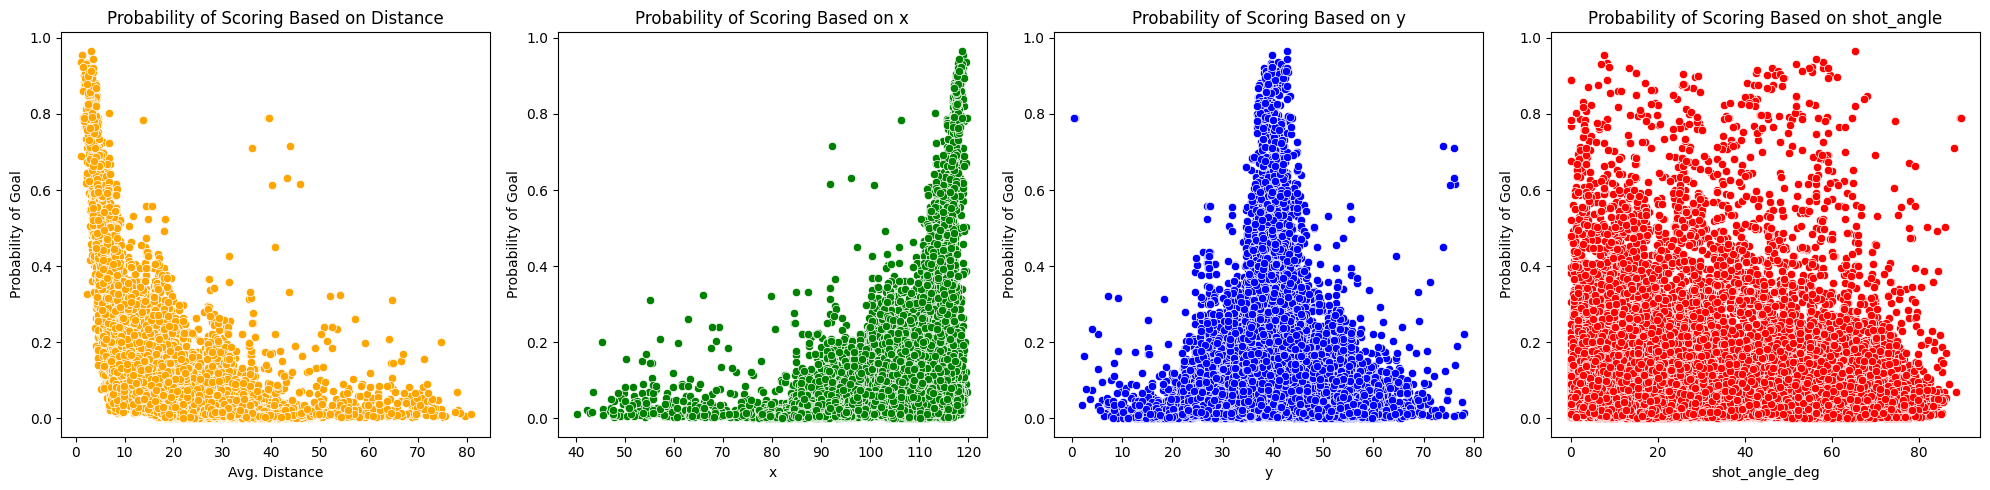

In [71]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

sns.scatterplot(x=df_shots_numeric['shot_distance'], y=df_shots_numeric['xG'], ax=axes[0], color="orange")
axes[0].set_xlabel("Avg. Distance")
axes[0].set_ylabel("Probability of Goal")
axes[0].set_title("Probability of Scoring Based on Distance")

sns.scatterplot(x=df_shots_numeric['x'], y=df_shots_numeric['xG'], ax=axes[1], color="green")
axes[1].set_xlabel("x")
axes[1].set_ylabel("Probability of Goal")
axes[1].set_title("Probability of Scoring Based on x")

sns.scatterplot(x=df_shots_numeric['y'], y=df_shots_numeric['xG'], ax=axes[2], color="blue")
axes[2].set_xlabel("y")
axes[2].set_ylabel("Probability of Goal")
axes[2].set_title("Probability of Scoring Based on y")

sns.scatterplot(x=df_shots_numeric['shot_angle_deg'], y=df_shots_numeric['xG'], ax=axes[3], color="red")
axes[3].set_xlabel("shot_angle_deg")
axes[3].set_ylabel("Probability of Goal")
axes[3].set_title("Probability of Scoring Based on shot_angle")


plt.tight_layout()
plt.show()

## Top 7 Leagues 2023/24 xG Analysis

### Team Analysis

In [37]:
xg_team = df_shots.groupby('team_id')[['xG','is_goal','is_shot']].sum().reset_index()
xg_team = pd.merge(xg_team, df_teams,on='team_id')
xg_team = xg_team[['team_id', 'team_name', 'xG', 'is_goal','is_shot']]
xg_team['xG-G'] = xg_team['xG']-xg_team['is_goal']
xg_team = xg_team.rename(columns={'is_goal': 'goals','is_shot':'shots'})
xg_team.sort_values(by='xG',ascending=False,inplace=True)

In [38]:
xg_team.head()

,team_id,team_name,xG,goals,shots,xG-G
51,129,PSV-Eindhoven,93.990013,108,789,-14.009987
4,26,Liverpool,87.206497,80,790,7.206497
77,256,Feyenoord,84.632835,90,701,-5.367165
0,13,Arsenal,79.229721,86,657,-6.770279
11,37,Bayern-Munich,79.097443,93,638,-13.902557


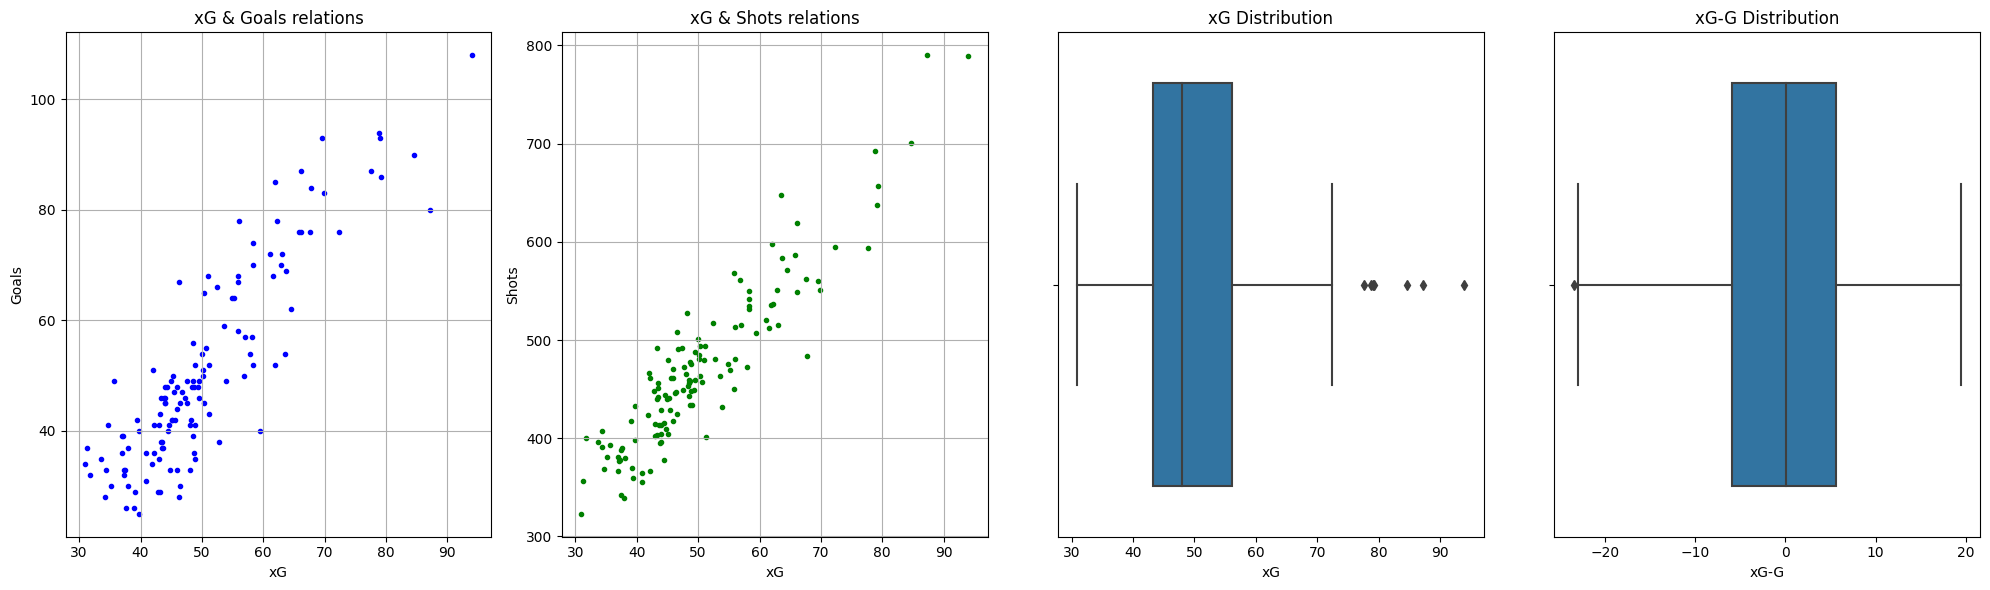

In [47]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))

# Plot for xG vs Goals
ax[0].scatter(xg_team.xG, xg_team.goals, marker='.', color='b')
ax[0].set_xlabel('xG')
ax[0].set_ylabel('Goals')
ax[0].set_title('xG & Goals relations')
ax[0].grid(True)

# Plot for xG vs Shots
ax[1].scatter(xg_team.xG, xg_team.shots, marker='.', color='g')
ax[1].set_xlabel('xG')
ax[1].set_ylabel('Shots')
ax[1].set_title('xG & Shots relations')
ax[1].grid(True)

# Boxplot for xG distribution
sns.boxplot(x=xg_team["xG"], ax=ax[2])
ax[2].set_title('xG Distribution')

# Boxplot for xG-G distribution
sns.boxplot(x=xg_team["xG-G"], ax=ax[3])
ax[3].set_title('xG-G Distribution')

plt.tight_layout()
plt.show()

### Players Analysis

In [44]:
xg_player = df_shots.groupby('player_id')[['xG','is_goal','is_shot']].sum().reset_index()
xg_player = pd.merge(xg_player,df_players[['player_id','player_name','team_name']],on='player_id')
xg_player = xg_player[['player_id', 'player_name', 'team_name', 'xG', 'is_goal','is_shot']]
xg_player['xG-G'] = xg_player['xG']-xg_player['is_goal']
xg_player = xg_player.rename(columns={'is_goal': 'goals','is_shot':'shots'})
xg_player.sort_values(by='xG',ascending=False,inplace=True)

In [45]:
xg_player.head()

,player_id,player_name,team_name,xG,goals,shots,xG-G
110,68585,Luuk de Jong,PSV-Eindhoven,28.651287,29,145,-0.348713
199,83532,Harry Kane,Bayern-Munich,26.104624,36,146,-9.895376
1063,315227,Erling Haaland,Manchester-City,24.166168,27,121,-2.833832
944,296975,Artem Dovbyk,Girona,20.728018,24,85,-3.271982
1219,330514,Vangelis Pavlidis,AZ-Alkmaar,19.580627,29,122,-9.419373


In [49]:
xg_player = xg_player[xg_player['shots']>5]

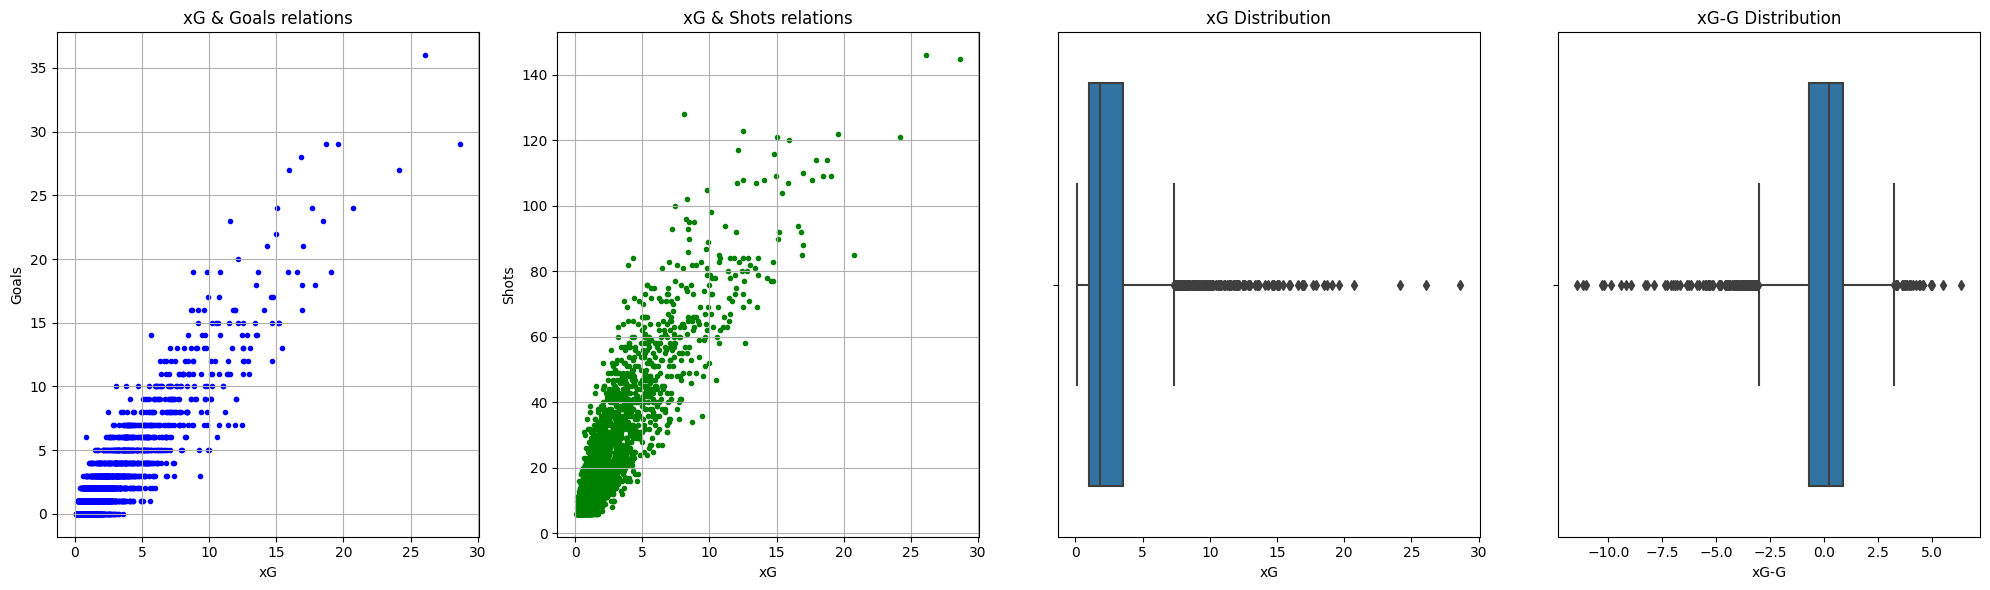

In [55]:
fig, ax = plt.subplots(1, 4, figsize=(20, 6))

# Plot for xG vs Goals
ax[0].scatter(xg_player.xG, xg_player.goals, marker='.', color='b')
ax[0].set_xlabel('xG')
ax[0].set_ylabel('Goals')
ax[0].set_title('xG & Goals relations')
ax[0].grid(True)

# Plot for xG vs Shots
ax[1].scatter(xg_player.xG, xg_player.shots, marker='.', color='g')
ax[1].set_xlabel('xG')
ax[1].set_ylabel('Shots')
ax[1].set_title('xG & Shots relations')
ax[1].grid(True)

# Boxplot for xG distribution
sns.boxplot(x=xg_player["xG"], ax=ax[2])
ax[2].set_title('xG Distribution')

# Boxplot for xG-G distribution
sns.boxplot(x=xg_player["xG-G"], ax=ax[3])
ax[3].set_title('xG-G Distribution')

plt.tight_layout()
plt.show()

# MODEL SUMMARY

## Functions summary to be used on other DB

In [56]:
def transform_data(df_events):
    
    # Apply transformations to x and y coordinates (intially 100 x 100)
    for col in ['x', 'end_x','blocked_x']:
        df_events.loc[:, col] *= 1.2
    for col in ['y', 'end_y', 'blocked_y', 'goal_mouth_y']:
        df_events.loc[:, col] = 80 - (df_events[col] * 0.8)    

    df_shots = df_events[(df_events['is_shot']==1) & (df_events['x']>40)]

    df_shots.loc[:, 'is_penalty'] = np.where((df_shots['x'] == 106.2) & (df_shots['y'] == 40), 1, 0)
        
    # Goal center coordinates
    goal_x = 120
    goal_y = 40

    # Calculate shot distance & angle

    df_shots['shot_distance'] = np.sqrt((df_shots['x'] - goal_x)**2 + (df_shots['y'] - goal_y)**2)
    
    df_shots['shot_angle'] = np.arctan2(np.abs(df_shots['y'] - goal_y), np.abs(goal_x - df_shots['x']))
    df_shots['shot_angle_deg'] = np.degrees(df_shots['shot_angle'])
    df_shots = df_shots.drop(columns=['shot_angle'])

    return df_shots

In [57]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

def xG_calculation(df_shots):
    
    # Define features and target
    features = ['shot_distance', 'shot_angle_deg','is_penalty','x','y']
    target = 'is_goal'
    
    # Define feature matrix and target vector
    X = df_shots[features]
    y = df_shots[target]
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    X_train_scaled = X_train  
    X_test_scaled = X_test
    
    xgb_model = xgb.XGBClassifier(eval_metric='logloss', use_label_encoder=False)
    
    xgb_model.fit(X_train_scaled, y_train)
    
    y_pred_xgb = xgb_model.predict(X_test_scaled)
    y_prob_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
    
    # Create a subset DataFrame with only the features required for prediction
    df_shots_numeric = df_shots[features]
    
    # Generate xG predictions based on the selected numeric columns
    xg_predictions = xgb_model.predict_proba(df_shots_numeric)[:, 1]  # Get probability for 'goal' (class 1)
    
    #Add the xG predictions back to the original DataFrame
    df_shots['xG'] = xg_predictions

    return df_shots

In [58]:
query_test = "SELECT * FROM match_events_2024_25"
df_events_test = pd.read_sql(query_test, engine)

In [59]:
df_shots_test = transform_data(df_events_test)
df_shots_test = xG_calculation(df_shots_test)

In [62]:
df_shots_test.head()

,id,match_id,event_id,minute,second,team_id,player_id,x,y,end_x,...,is_shot,card_type,is_goal,type_display_name,outcome_type_display_name,period_display_name,is_penalty,shot_distance,shot_angle_deg,xG
24,2706934411,1822174,19,2,13.0,758,79967,93.84,50.72,NaN,...,1,0,0,SavedShot,Successful,FirstHalf,0,28.271257,22.283128,0.027116
30,2706934731,1822174,24,2,35.0,758,321106,97.56,53.28,NaN,...,1,0,0,SavedShot,Successful,FirstHalf,0,26.075122,30.617062,0.016722
69,2706936555,1822174,35,4,45.0,783,484534,89.16,23.84,NaN,...,1,0,0,MissedShots,Successful,FirstHalf,0,34.817398,27.654305,0.023403
85,2706938913,1822174,63,7,40.0,758,79967,106.20,40.00,NaN,...,1,0,1,Goal,Successful,FirstHalf,1,13.800000,0.000000,0.839903
93,2706939645,1822174,50,8,43.0,783,423275,100.92,24.80,NaN,...,1,0,0,SavedShot,Successful,FirstHalf,0,24.394393,38.542429,0.013561
